# 01. Fashion MNIST CNN

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
print('train_input:', train_input.shape)
print('train_target:', train_target.shape)
print('test_input:', test_input.shape)
print('test_target:', test_target.shape)

train_input: (60000, 28, 28)
train_target: (60000,)
test_input: (10000, 28, 28)
test_target: (10000,)


In [3]:
# 입력 데이터 4차원으로 변경 + 정규화
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0   # (데이터 개수, 행, 열, 채널)  *-1은 자동적으로 채워달라는 가변적인 값

In [4]:
# train_test_split으로 데이터 분할
train_input_tr, val_input, train_target_tr, val_target = train_test_split(train_scaled, 
                                                                            train_target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
print('train_input_tr:', train_input_tr.shape)
print('train_target_tr:', train_target_tr.shape)
print('val_input:', val_input.shape)
print('val_target:', val_target.shape)

train_input_tr: (48000, 28, 28, 1)
train_target_tr: (48000,)
val_input: (12000, 28, 28, 1)
val_target: (12000,)


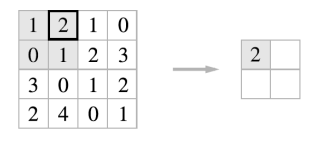

In [5]:
# CNN(합성곱) 신경망 구성
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=32,
                              kernel_size=(3, 3),
                              padding='same',
                              strides=1,
                              input_shape=(28, 28, 1),  # 행-열-면(채널) 순서로 입력(흑백 이미지는 채널 1개, 컬러 이미지는 채널 3개)
                              activation='relu'
                             ))
# Conv2D 클래스로 Conv 계층 생성 (Conv2D: 4차원의 입력 데이터를 받아 2차원으로 내부에서 변환)
# filter: filter의 개수 (가장 많이 사용하는 값 32)
# kernel_size: 필터의 크기
# padding='same': 출력 사이즈가 입력의 사이즈와 동일하도록 패딩을 설정해줌
# strides: default값 1

# 같은 레이어의 pooling 적용 (MaxPooling2D: Conv에서 생성된 shape을 쪼개 가장 큰 값을 취하는 알고리즘)
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# MaxPooling: 최댓값을 취하는 풀링(주로 이걸 사용), AveragePooling: 평균값을 취하는 풀링
# pool_size가 2*2: 위 사진에서 회색의 칸이 2*2라는 말
# >> 28*28 사이즈에 2*2 풀링을 적용하면 14*14가 됨

In [6]:
# 두 번째 망
model.add(keras.layers.Conv2D(filters=64,
                              kernel_size=(3, 3),
                              padding='same',
                              strides=1,
                              input_shape=(28, 28, 1),  # 행-열-면(채널) 순서로 입력(흑백 이미지는 채널 1개, 컬러 이미지는 채널 3개)
                              activation='relu'
                             ))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))  # 4차원의 출력값이 됨
# pool_size가 2*2: 위 사진에서 회색의 칸이 2*2라는 말
# >> 14*14 사이즈에 2*2 풀링을 적용하면 7*7이 됨

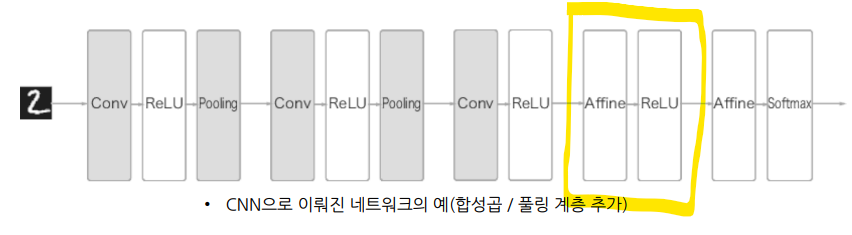

- 완전연결계층 단계

In [7]:
# 완전연결계층을 연결 (Affine-ReLU)
model.add(keras.layers.Flatten())  # Affine에 넣기 위해서는 지난 레이어의 4차원 데이터를 1차원으로 만들어줘야 함

model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(keras.layers.Dropout(0.4))   # 과대적합 방지 (학습할 때만 적용됨, 예측 시는 적용X)

# 출력 레이어 구성
model.add(keras.layers.Dense(units=10,              # target의 카테고리와 같은 값
                             activation='softmax')) # 마지막 연결 레이어의 활성화함수는 항상 softmax

In [8]:
model.summary()

# (conv에서는 filter가 weight)
# 320: w의 수(filter의 개수 32 * 각 filter의 칸 9) + bias 32
# 18496: 두 번째 레이어의 입력값(== 첫 번째 레이어를 통해 나오는 결과) 32개 * filter의 개수 64 * 각 filter의 칸 9 + bias 64
# 313700: flatten한 입력값 (3136) * 출력값 100 + bias 100
# 1010: 입력값(윗 단계의 출력값) 100개 * 출력값 10개 + bias 10개

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [9]:
# 모델 학습
model.compile(loss='sparse_categorical_crossentropy',   # 원핫인코딩을 대신 해주는 sparse_..
              optimizer='adam',                         # momentum + adaGrad
              metrics='accuracy')

In [10]:
acc = model.fit(train_input_tr,
                train_target_tr,
                epochs=50,
                batch_size=100,
                verbose=1,                 # default:1 (학습 결과를 보여줌) <-> 0: 보여주지 않음
                validation_data=(val_input, val_target))           # 검증용 데이터를 미리 넣어줌

Epoch 1/50
480/480 [==============================] - 19s 39ms/step - loss: 0.6080 - accuracy: 0.7851 - val_loss: 0.3626 - val_accuracy: 0.8723
Epoch 2/50
480/480 [==============================] - 20s 42ms/step - loss: 0.3908 - accuracy: 0.8626 - val_loss: 0.3069 - val_accuracy: 0.8850
Epoch 3/50
480/480 [==============================] - 19s 40ms/step - loss: 0.3358 - accuracy: 0.8793 - val_loss: 0.2870 - val_accuracy: 0.8921
Epoch 4/50
480/480 [==============================] - 20s 41ms/step - loss: 0.3022 - accuracy: 0.8913 - val_loss: 0.2686 - val_accuracy: 0.8988
Epoch 5/50
480/480 [==============================] - 19s 40ms/step - loss: 0.2805 - accuracy: 0.8988 - val_loss: 0.2532 - val_accuracy: 0.9036
Epoch 6/50
480/480 [==============================] - 19s 40ms/step - loss: 0.2614 - accuracy: 0.9056 - val_loss: 0.2628 - val_accuracy: 0.9020
Epoch 7/50
480/480 [==============================] - 20s 42ms/step - loss: 0.2446 - accuracy: 0.9108 - val_loss: 0.2440 - val_accuracy:

In [11]:
model.evaluate(val_input, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.4243 - accuracy: 0.9236


[0.4242801368236542, 0.9235833287239075]